### 21/10/2024

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib widget

In [2]:
bias_list = np.genfromtxt('../group08_HAT-P-12_20230214/bias/bias_list.txt', dtype=str)
print(bias_list)

['AF824296.fits' 'AF824297.fits' 'AF824298.fits' 'AF824299.fits'
 'AF824300.fits' 'AF824301.fits' 'AF824302.fits' 'AF824303.fits'
 'AF824304.fits' 'AF824305.fits' 'AF824306.fits' 'AF824307.fits'
 'AF824308.fits' 'AF824309.fits' 'AF824310.fits' 'AF824311.fits'
 'AF824312.fits' 'AF824313.fits' 'AF824314.fits' 'AF824315.fits'
 'AF824316.fits' 'AF824317.fits' 'AF824318.fits' 'AF824319.fits'
 'AF824320.fits' 'AF824321.fits' 'AF824322.fits' 'AF824323.fits'
 'AF824324.fits' 'AF824325.fits']


In [3]:
bias00_fits = fits.open('../group08_HAT-P-12_20230214/bias/'+bias_list[0]) #takes the first bias .fits file
bias00_hdu = bias00_fits[0] #selects the PrimaryHDU
print(bias00_hdu)

In [4]:
bias00_hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  521 / length of data axis 1                          
NAXIS2  =                  156 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2023-02-15T05:14:25' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
FILENAME= 'AF824296.fits'      / Original file name                             
TIMESYS = 'UTC     '        

In [5]:
bias00_time = bias00_hdu.header['JD']
bias00_airmass = bias00_hdu.header['AIRMASS']
bias00_gain = bias00_hdu.header['GAIN']
bias00_gain_comment = bias00_hdu.header.comments['GAIN'] #unit
bias00_readout_noise = bias00_hdu.header['RDNOISE']
bias00_ron_comment = bias00_hdu.header.comments['RDNOISE']

print('Julian date : {0:12.6f} JD'.format(bias00_time)) #converted to UTC: 2023-02-15 05:14:25.094
print('CCD Gain : {0:3.2f} {1:.7s}'.format(bias00_gain, bias00_gain_comment)) #converts ADU in electrons (WATCH OUT! some instruments have an opposite definition, i.e. [ADU/e])
print('CCD Readout noise: {0:3.2f} {1:.3s}'.format(bias00_readout_noise, bias00_ron_comment))

#regarding the formatting: {0:3.2f} means that it will print four significative figures, two of which decimal, of the first argument in .format((var, var2))

Julian date : 2459990.718346 JD
CCD Gain : 1.91 [e/ADU]
CCD Readout noise: 7.10 [e]


Since the RON is in [e], it is convenient to convert all the errors in [e] in order to perform statistical analysis.

### 23/10/2024

The RON *cannot* be removed. The bias is analyzed to remove the systematics.

In [6]:
bias00_data = bias00_hdu.data * bias00_gain   #converted to electrons
bias00_data

array([[2792.42, 2765.68, 2784.78, ..., 2779.05, 2775.23, 2773.32],
       [2780.96, 2780.96, 2775.23, ..., 2773.32, 2763.77, 2777.14],
       [2771.41, 2773.32, 2761.86, ..., 2773.32, 2779.05, 2780.96],
       ...,
       [2777.14, 2763.77, 2767.59, ..., 2763.77, 2767.59, 2780.96],
       [2769.5 , 2761.86, 2750.4 , ..., 2767.59, 2775.23, 2779.05],
       [2780.96, 2771.41, 2782.87, ..., 2771.41, 2784.78, 2767.59]])

In [7]:
print(bias00_hdu.header['NAXIS1'])
print(bias00_hdu.header['NAXIS2'])

521
156


In [8]:
np.shape(bias00_data) #OSS the axis are rotated, see notes. astropy uses a reversed notation for rows x columns

(156, 521)

In [9]:
#save the data in a datacube (x_bias, y_bias, bias_frame) and then evaluate the median (it is faster)

dim00, dim01 = np.shape(bias00_data)
print(dim00, dim01)

156 521


In [10]:
n_images = len(bias_list) #we check the number of frames since we might have commented the original file because some frames may be damaged or not good for the analysis
n_images

30

In [11]:
stack = np.empty([n_images, dim00, dim01])
print(np.shape(stack))
print(stack[:, 0, 0])   #first entry of every frame

(30, 156, 521)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [12]:
for i, name in enumerate(bias_list):    #enumerate gives an ID to every element of the array
    #print(i, name)
    bias_temp = fits.open('../group08_HAT-P-12_20230214/bias/' + name)
    stack[i, :, :] = bias_temp[0].data * bias_temp[0].header['GAIN']    #we saved the bias data multiplied by the gain (to convert into electrons) in the stack array
    bias_temp.close()

In [13]:
print(stack[:, 0, 0])

[2792.42 2775.23 2786.69 2769.5  2777.14 2771.41 2780.96 2786.69 2767.59
 2782.87 2767.59 2771.41 2769.5  2777.14 2780.96 2773.32 2779.05 2780.96
 2796.24 2773.32 2761.86 2777.14 2775.23 2779.05 2775.23 2780.96 2769.5
 2769.5  2767.59 2779.05]


If the array contains some nan entry, it is still possible to calculate the median/std by using *np.nanmedian*.

In [14]:
median_bias = np.median(stack, axis = 0)
print(np.shape(median_bias))    #checking. the frames have been collapsed to a single value

(156, 521)


In [15]:
print(np.amin(bias00_data))
print(np.amax(bias00_data))

2744.67
2809.6099999999997


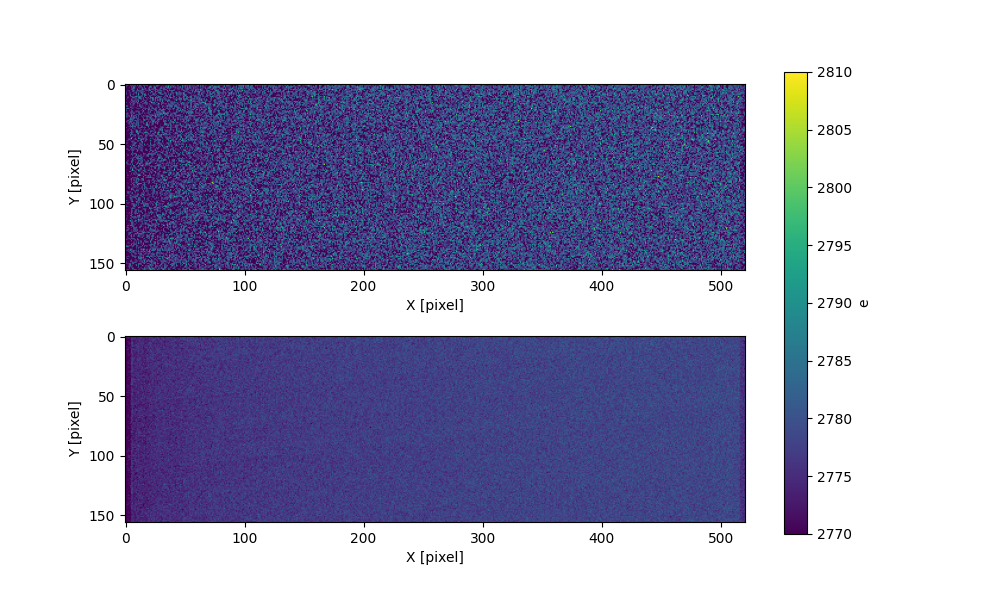

In [16]:
fig, ax = plt.subplots(2, figsize = (10, 6))

im1 = ax[0].imshow(bias00_data, vmin = 2770, vmax = 2810)
im2 = ax[1].imshow(median_bias, vmin = 2770, vmax = 2810)
cbar = fig.colorbar(im1, ax=ax)
cbar.set_label('e')
ax[0].set_xlabel('X [pixel]')
ax[0].set_ylabel('Y [pixel]')
ax[1].set_xlabel('X [pixel]')
ax[1].set_ylabel('Y [pixel]')
plt.show()

#the noise is reduced! :)
#however we can see that there is a gradient on the CCD

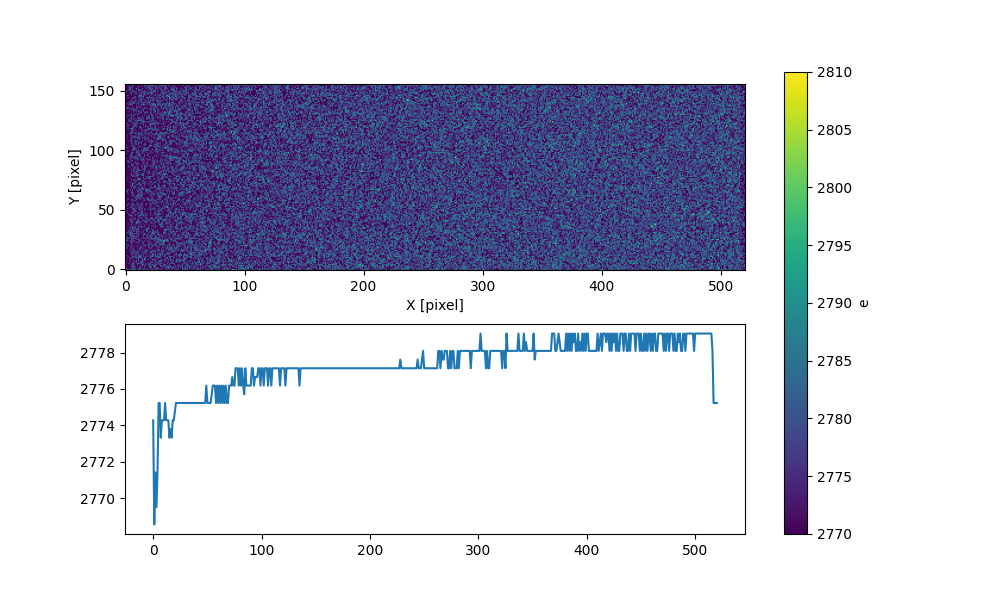

In [17]:
#in astronomy (e.g. DS9) we start counting from the lower left corner

fig, ax = plt.subplots(2, figsize = (10, 6))

im1 = ax[0].imshow(bias00_data, vmin = 2770, vmax = 2810, origin='lower')

median_column = np.median(median_bias, axis=0)
im2 = ax[1].plot(median_column)

cbar = fig.colorbar(im1, ax=ax)
cbar.set_label('e')
ax[0].set_xlabel('X [pixel]')
ax[0].set_ylabel('Y [pixel]')

plt.show()

The "jumps" are due to the fact that the bias in ADU is given by integers numbers. The median is always an integer while the mean is a float $\rightarrow$ continuous plot. In fact:

In [18]:
integer_distrib = np.random.randint(0, 100, 30)
print(np.median(integer_distrib))
print(np.mean(integer_distrib))
#median =/= mean (unless you have a gaussian distribution)

53.0
52.36666666666667


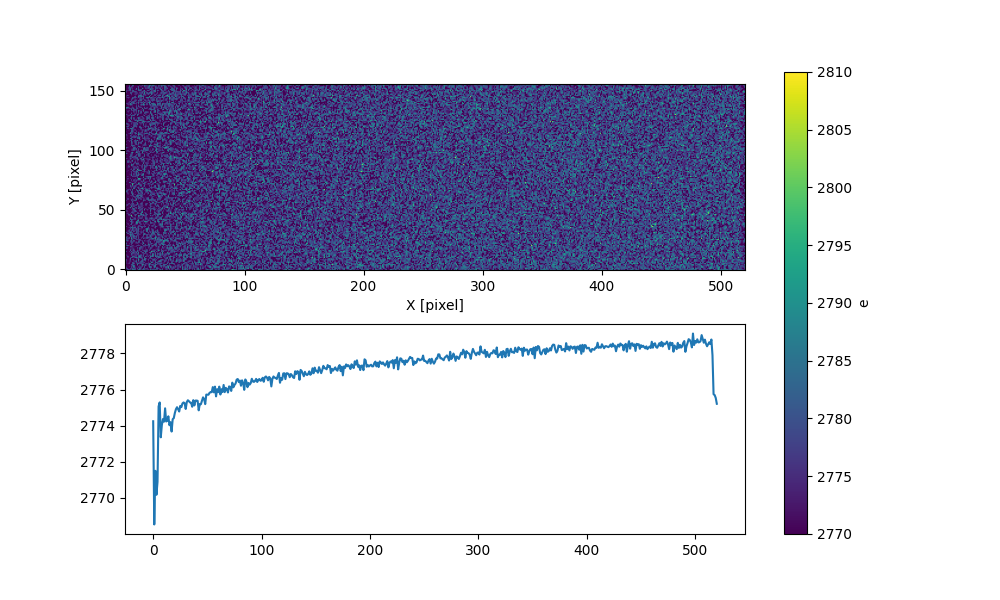

In [19]:
fig, ax = plt.subplots(2, figsize = (10, 6))

im1 = ax[0].imshow(bias00_data, vmin = 2770, vmax = 2810, origin='lower')

median_column = np.mean(median_bias, axis=0)
im2 = ax[1].plot(median_column)

cbar = fig.colorbar(im1, ax=ax)
cbar.set_label('e')
ax[0].set_xlabel('X [pixel]')
ax[0].set_ylabel('Y [pixel]')

plt.show()

#now it is smoothed and continuous :)

### 28/10/2024